In [1]:
#imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sklm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

<h1>Dataset</h1>
The dataset is the Current Population Survey (CPS) data from 1985, containing demographic factors, and hourly wage. The survey was conducted in the US. The dataset contains the following variables:<br>
1) Wage (hourly wage in 1985 $USD)<br>
2) Occupation (1: Management, 2: Sales, 3: Clerical, 4: Service, 5: Professional, 6: Other)<br>
3) Sector (0: Other, 1: Manufacturing, 2: Construction)<br>
4) Union (1: Member, 2: Not a member)<br>
5) Education (years of education)<br>
6) Experience (years of work experience)<br>
7) Age (years)<br>
8) Sex (1: Female, 0: Male)<br>
9) Marr (marital status; 1: married, 0: not married)<br>
10) Race (1: Other, 2: Hispanic, 3: White)<br>
11) South (whether person lives in southern region; 1: True, 2: False)<br>
<br>
We would like to explore the dataset to try and determine what factors were the most helpful in predicting hourly wage. For the sake of explorataion, we are going to try 2 modeling approaches:<br>
1) Predicting wage as a continuous variable<br>
2) Predicting whether someone earns at or above the median wage

<h1>EDA</h1>

In [2]:
# load the dataset
df = pd.read_csv("wage.data.txt", delim_whitespace=True)
df.head()

,education,south,sex,experience,union,wage,age,race,occupation,sector,marr
0,8,0,1,21,0,5.10,35,2,6,1,1
1,9,0,1,42,0,4.95,57,3,6,1,1
2,12,0,0,1,0,6.67,19,3,6,1,0
3,12,0,0,4,0,4.00,22,3,6,0,0
4,12,0,0,17,0,7.50,35,3,6,0,1


<h2>Missing/Extreme Values</h2>
Upon inspection, there were no missing values, or extreme or erroneous outliers within the data.

<h2>Distributions of Variables</h2>

In our EDA, we found out the following information about the distributions of the various variables:<br>
1) majority of education is 12<br>
2) south is disproportionate to 0<br>
3) union is disproportionate to 0<br>
4) race is disproportionate to 3<br>
5) distribution of occupation is expected - moving down the managment chain<br>
6) sector is disproportionate to 0<br>
7) experience is left-skewed (fixed by sqrt)<br>
8) wage is left-skewed (fixed by log)<br>
9)  is a left-skewed (fixed by log)<br>
<br>
For the sake of brevity, we will only includea plot for the distribution of the education variable, as it is hard to describe verbally.

<Axes: xlabel='education', ylabel='count'>

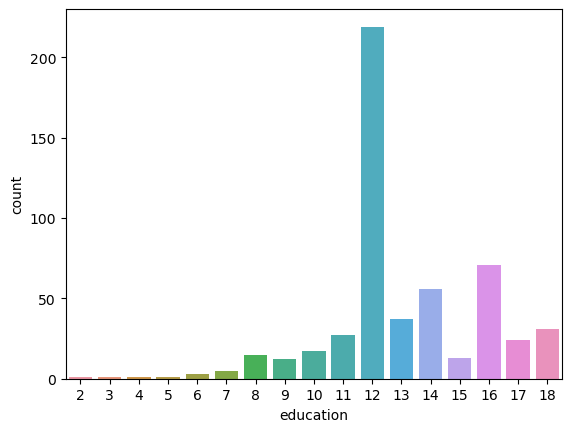

In [3]:
sns.countplot(x=df.education)

<h2>Relationships between Wage and Other Variables</h2>

In our EDA, we found no relationships between wage and the continuous variables (including education). So, we compared both the mean wages and the median wages for the various values in the categorical variables.

In [4]:
# comparing mean wages by variable
print(df.groupby("south").agg({"wage": "mean"}))
print(df.groupby("sex").agg({"wage": "mean"}))
print(df.groupby("union").agg({"wage": "mean"}))
print(df.groupby("race").agg({"wage": "mean"}))
print(df.groupby("occupation").agg({"wage": "mean"}))
print(df.groupby("sector").agg({"wage": "mean"}))
print(df.groupby("marr").agg({"wage": "mean"}))

           wage
south          
0      9.489233
1      7.896923
         wage
sex          
0    9.994913
1    7.878857
            wage
union           
0       8.635228
1      10.798125
          wage
race          
1     8.058358
2     7.283333
3     9.277932
                 wage
occupation           
1           12.704000
2            7.592632
3            7.422577
4            6.537470
5           11.947429
6            8.426474
            wage
sector          
0       8.872774
1       9.604444
2       9.220833
          wage
marr          
0     8.311848
1     9.398486


We can see the following trends:<br>
1) non-south has higher average wages<br>
2) males have higher average wages<br>
3) union members have higher average wages<br>
4) race (mean wage, highest to lowest): 3, 1, 2<br>
5) occupation (same as race): 1, 5, (2,3), 6, 4<br>
6) sector (same as race): 1, 2, 0<br>
7) married individuals have higher mean wages than unmarried<br>
<br>
The mean wages for occupations 2 and 3 are quite similar. Additionally, the mean wages for sectors 1 and 2 are quite similar. We can check the difference in means with bootstrapping to get a better idea.

In [5]:
## check difference in mean wages for occupations 2 and 3
s1 = []
s2 = []

for i in range(1000):
    sample = df.loc[df.occupation==2, "wage"].sample(n=1000, replace=True)
    sample_mean = sample.mean()
    s1.append(sample_mean)
    
    sample = df.loc[df.occupation==3, "wage"].sample(n=1000, replace=True)
    sample_mean = sample.mean()
    s2.append(sample_mean)
    
s1 = np.array(s1)
s2 = np.array(s2)

<Axes: ylabel='Count'>

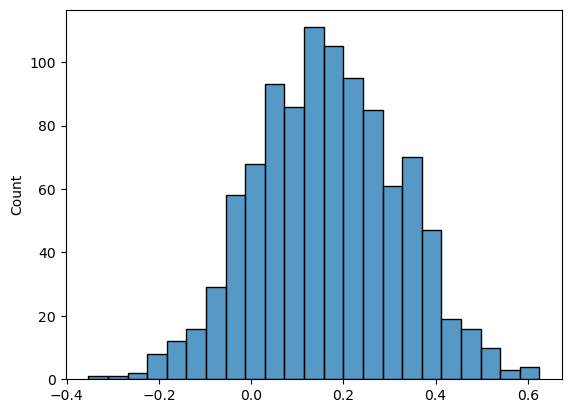

In [6]:
# look at histogram of difference in means
sns.histplot(s1 - s2)

The difference in means is not 0; therefore it would be useful to incorporate them separately in models

In [7]:
## check difference in mean wages for sectors 1 and 2
s1 = []
s2 = []

for i in range(1000):
    sample = df.loc[df.sector==1, "wage"].sample(n=1000, replace=True)
    sample_mean = sample.mean()
    s1.append(sample_mean)
    
    sample = df.loc[df.sector==2, "wage"].sample(n=1000, replace=True)
    sample_mean = sample.mean()
    s2.append(sample_mean)
    
s1 = np.array(s1)
s2 = np.array(s2)

<Axes: ylabel='Count'>

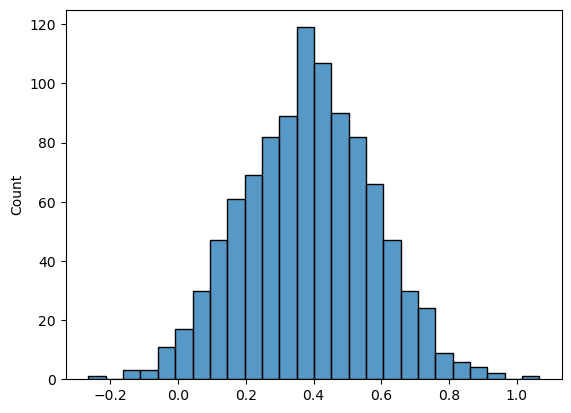

In [8]:
# look at histogram of difference in means
sns.histplot(s1 - s2)

Again, the difference in means is not 0. Therefore there is information to be extracted.

Now, let's compare the median wages by variable.

In [9]:
# comparing mean wages by variable
print(df.groupby("south").agg({"wage": "median"}))
print(df.groupby("sex").agg({"wage": "median"}))
print(df.groupby("union").agg({"wage": "median"}))
print(df.groupby("race").agg({"wage": "median"}))
print(df.groupby("occupation").agg({"wage": "median"}))
print(df.groupby("sector").agg({"wage": "median"}))
print(df.groupby("marr").agg({"wage": "median"}))

        wage
south       
0      8.595
1      6.250
     wage
sex      
0    8.93
1    6.80
        wage
union       
0       7.07
1      10.00
      wage
race      
1      7.5
2      5.2
3      8.0
              wage
occupation        
1           10.620
2            5.725
3            7.500
4            5.500
5           10.610
6            7.150
        wage
sector      
0       7.50
1       9.00
2       9.75
       wage
marr       
0     6.585
1     8.595


Again, the median wages for occupations 2 and 4 are quite similar. Let's inspect with bootstrapping.

In [10]:
## check difference in mean wages for occupations 2 and 3
s1 = []
s2 = []

for i in range(1000):
    sample = df.loc[df.occupation==2, "wage"].sample(n=1000, replace=True)
    sample_mean = sample.median()
    s1.append(sample_mean)
    
    sample = df.loc[df.occupation==4, "wage"].sample(n=1000, replace=True)
    sample_mean = sample.median()
    s2.append(sample_mean)
    
s1 = np.array(s1)
s2 = np.array(s2)

<Axes: ylabel='Count'>

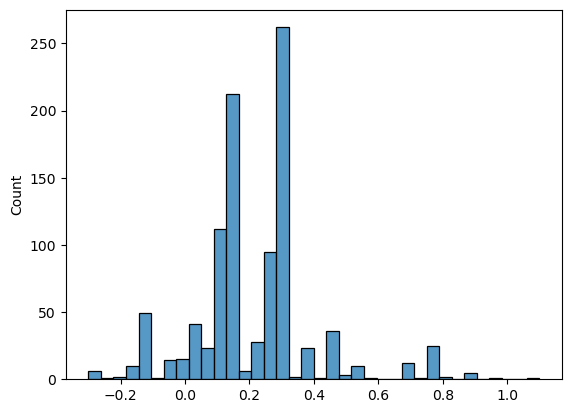

In [11]:
# look at histogram of difference in means
sns.histplot(s1 - s2)

The plot shows that the difference in medians is not in fact 0, though it is very close. Therefore it might be useful to extract information from these levels.

<h1>Modeling Continuous Wage<h1>

Since all categorical variables proved to have different mean wages for the various levels of each categorical variable, we shall include all of them as predictors. Furthermore, we used one-hot encoding for the variables with multiple levels so that coefficient interpretation may be easier. Due to the nature of the data, we began with ordinary linear regression.

In [13]:
# create one-hot for occupation
df["occ_1"] = df.occupation.apply(lambda x: 1 if x == 1 else 0)
df["occ_2"] = df.occupation.apply(lambda x: 1 if x == 2 else 0)
df["occ_3"] = df.occupation.apply(lambda x: 1 if x == 3 else 0)
df["occ_4"] = df.occupation.apply(lambda x: 1 if x == 4 else 0)
df["occ_5"] = df.occupation.apply(lambda x: 1 if x == 5 else 0)
df["occ_6"] = df.occupation.apply(lambda x: 1 if x == 6 else 0)

# create one-hot variables for sector
df["sec_0"] = df.sector.apply(lambda x: 1 if x == 0 else 0)
df["sec_1"] = df.sector.apply(lambda x: 1 if x == 1 else 0)
df["sec_2"] = df.sector.apply(lambda x: 1 if x == 2 else 0)

# create one-hot variables for race
df["race_1"] = df.race.apply(lambda x: 1 if x == 1 else 0)
df["race_2"] = df.race.apply(lambda x: 1 if x == 2 else 0)
df["race_3"] = df.race.apply(lambda x: 1 if x == 3 else 0)

In [13]:
# create one-hot for occupation
df["occ_1"] = df.occupation.apply(lambda x: 1 if x == 1 else 0)
df["occ_2"] = df.occupation.apply(lambda x: 1 if x == 2 else 0)
df["occ_3"] = df.occupation.apply(lambda x: 1 if x == 3 else 0)
df["occ_4"] = df.occupation.apply(lambda x: 1 if x == 4 else 0)
df["occ_5"] = df.occupation.apply(lambda x: 1 if x == 5 else 0)
df["occ_6"] = df.occupation.apply(lambda x: 1 if x == 6 else 0)

# create one-hot variables for sector
df["sec_0"] = df.sector.apply(lambda x: 1 if x == 0 else 0)
df["sec_1"] = df.sector.apply(lambda x: 1 if x == 1 else 0)
df["sec_2"] = df.sector.apply(lambda x: 1 if x == 2 else 0)

# create one-hot variables for race
df["race_1"] = df.race.apply(lambda x: 1 if x == 1 else 0)
df["race_2"] = df.race.apply(lambda x: 1 if x == 2 else 0)
df["race_3"] = df.race.apply(lambda x: 1 if x == 3 else 0)

In [14]:
## define training and testing splits
X = df.drop(["education", "experience", "wage", "age", "race", "occupation", "sector"], axis=1)
y = df.wage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
## define and fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# test model performance
preds = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, preds)))
print(r2_score(y_test, preds))

3.993854877855836
0.3233058395709789


The RMSE and R2 values don't look too good for the regular linear regression model. Let's inspect the coefficients with a plot.

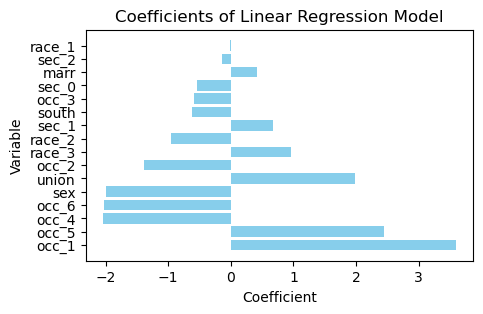

In [25]:
#### Get the coefficients of the linear regression model
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': model.coef_})

# Plot coefficients to visualize the impact of each variable on wage
plt.figure(figsize=(5,3))
plt.barh(coefficients['Variable'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.title('Coefficients of Linear Regression Model')
plt.show()

We see from the plot above that some coefficients are quite close to 0. We will first look at LASSO regression, as that will reduce the coefficients of non-existent effects all the way to 0, unlike Ridge. However, we will still look at Ridge regression for comparison purposes.

In [26]:
## perform LASSO regression
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
model_lasso_cv = LassoCV(alphas=np.arange(0.001, 0.1, 0.001), max_iter=10000, cv=cv, random_state=0)
model_lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099]),
        cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=0),
        max_iter=10000, random_state=0)

Let's inspect a coefficient plot for the LASSO model.

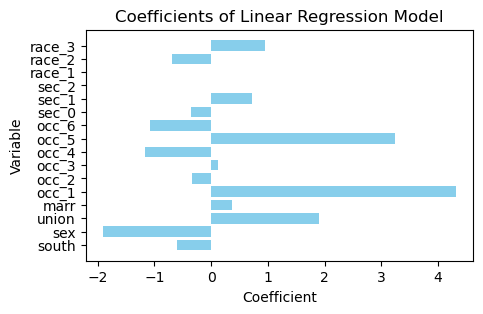

In [38]:
#### Get the coefficients of the linear regression model
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': model_lasso_cv.coef_})

# Plot coefficients to visualize the impact of each variable on wage
plt.figure(figsize=(5,3))
plt.barh(coefficients['Variable'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.title('Coefficients of Linear Regression Model')
plt.show()

We can see in the plot above that the effects of race=1 (other) and sector=2 (manufacturing) have been completely reduced to 0. Let's look at how the model performs.

In [28]:
# indeed, some factors are now 0; let's see how this model performs
preds = model_lasso_cv.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, preds)))
print(r2_score(y_test, preds))

3.999113993805962
0.3215225218053662


The RMSE and R2 values of the LASSO model are identical to those of the regular linear regression model. This is interesting as regularizing the coefficients should have led to better accuracy on the test data. However, it seems that this is not true. Let's next try a Ridge model to see if that has any improved accuracy.

In [31]:
# train a ridge model
model_ridge_cv = RidgeCV(alphas=np.arange(0.001, 0.1, 0.001), cv=cv)
model_ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099]),
        cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=0))

Now let's see if the Ridge regression performs any better than the regular or LASSO regression models.

In [32]:
# indeed, some factors are now 0; let's see how this model performs
preds = model_ridge_cv.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, preds)))
print(r2_score(y_test, preds))

3.9939794154858412
0.32326363713574613


Again, it performs identically. In this scenario, for prediction purposes, it might prove best to use ordinary linear regression as complicating the model doesn't prove useful. For the sake of simplicity, to look at the effects of the various factors, we shall use the coefficients from LASSO regression.

In [41]:
# print the coefficients of the LASSO model
print(model_lasso_cv.intercept_)
print(coefficients)

8.273494194648212
   Variable  Coefficient
0     south    -0.597893
1       sex    -1.900044
2     union     1.910523
3      marr     0.366581
4     occ_1     4.308504
5     occ_2    -0.341762
6     occ_3     0.125929
7     occ_4    -1.156530
8     occ_5     3.234756
9     occ_6    -1.073443
10    sec_0    -0.355296
11    sec_1     0.719953
12    sec_2    -0.000000
13   race_1     0.000000
14   race_2    -0.692164
15   race_3     0.953182


The model coefficients tell us the following (with the average wage being $8.27):<br>
1) people in South earn 0.60 less than the average wage<br>
2) females earn 1.90 less than the average wage<br>
3) union members earn 1.91 more than the average wage<br>
4) married individuals earn 0.37 more than the average wage<br>
5) people in management earn 4.31 more than the average wage<br>
6) people in sales earn 0.34 less than the average wage<br>
7) people in clerical 0.13 more than the average wage<br>
8) people in services 1.16 less than the average wage<br>
9) people in professional occupations 3.23 more than the average wage<br>
10) people not in the above occupations 1.07 less than the average wage<br>
11) people not in manufacturing or construction earn 0.36 less than the average wage<br>
12) people in manufacturing earn 0.72 more than the average wage<br>
13) Hispanics earn 0.69 less than the average wage<br>
14) Whites earn 0.95 less than the average wage<br>

<h1>Modeling Median Wage</h1>

For the next few models, we are going to use a binary variable that is 1 if the person earns at or above the median wage, and 0 otherwise. We tried a decision tree, as well as logistic regression.

In [43]:
# create a binary wage variable: above and not above the median
df["above_median"] = df.wage.apply(lambda x: 1 if x >= df.wage.median() else 0)

In [46]:
## define train and test splits
X = df.loc[:, ["sex", "south", "union", "occupation", "sector", "marr"]]
y = df.above_median

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [48]:
# see model accuracy
preds = model.predict(X_test)
confusion_matrix(y_test, preds)

array([[44,  9],
       [24, 30]], dtype=int64)

precision = 44 / 53 = 0.830<br>
recall = 44/68 = 0.647<br>
f1-score = 0.727<br>
misclassification rate = 33/107 = 0.308<br>

While the misclassification rate is somewhat high, all measures of accuracy are quite good and the model is reasonably accurate. Let's now look at logistic regression.